In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import joblib

import datetime
from ngram import *
from baselines import *
from error_analysis import *
import os
import fnmatch
import numpy as np
import time
import multiprocessing as mp
import re 

In [2]:
import inspect, os
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
os.sys.path.insert(0,parentdir) 
from data_generation.diff_utils import clean_and_filter

# Run Models

#### Load Models

In [14]:
m_agg = joblib.load( '../../models/aggression_classification_ngram.pkl')
m_rec = joblib.load( '../../models/recipient_ngram.pkl')

#### Load annotationed diffs

In [15]:
def apply_models(df):
    diffs = df['clean_diff']
    agg_scores = m_agg.predict_proba(df['clean_diff'])
    df['pred_aggression_score'] = agg_scores.dot(np.array([1, 0, -1]))
    df['pred_aggressive'] = agg_scores[:, 0]
    df['pred_neutral'] = agg_scores[:, 1]
    df['pred_friendly'] = agg_scores[:, 2]
    rec_scores = m_rec.predict_proba(df['clean_diff'])
    df['pred_recipient_score'] = rec_scores[:,1]
    return df
    

In [8]:
_ , d_r = load_cf_data()
d_annotations = tidy_labels(d_r)

d_annotations['aggression_score'] = d_annotations['aggression_score'].apply(map_aggression_score_to_3class)*-1 + 1

d_annotated = d_annotations\
            .drop_duplicates(subset=['rev_id'])\
            .assign(
                recipient = plurality(d_annotations['recipient'].dropna()),
                recipient_score = average(d_annotations['recipient'].dropna()),
                aggression = plurality(d_annotations['aggression_score'].dropna()),
                aggression_score = average(d_annotations['aggression_score'].dropna()))
            

        
d_annotated.to_csv('../../data/v4/user/clean/d_annotated.tsv', sep = '\t')

#### Load samples and apply models

We take various diffs datasets from hive, apply the clean and filter function and the score the clean diffs using the models.

In [30]:
def pred_helper(df):
    if len(df) == 0:
        return None
    
    return df.assign(rev_timestamp = lambda x: pd.to_datetime(x.rev_timestamp),
                     clean_diff = lambda x: x['clean_diff'].astype(str))\
             .pipe(apply_models)

    
def prep_in_parallel(path, k = 8):
    df = pd.read_csv(path, sep = '\t', encoding = 'utf-8')\
           .assign(key = lambda x: np.random.randint(0, high=5*k, size=x.shape[0]))
    dfs = [e[1] for e in df.groupby('key')]
    p = mp.Pool(k)
    dfs = p.map(pred_helper, dfs)
    p.close()
    p.join()
    return pd.concat(dfs)

In [33]:
base = '../../data/v4/'
nss = ['article']
samples = ['talk_diff_no_admin_sample.tsv', 'talk_diff_no_admin_2015.tsv', 'all_blocked_user.tsv', 'd_annotated.tsv']



In [32]:
base_cols = ['rev_id', 'clean_diff', 'rev_timestamp', 'pred_aggression_score', 'pred_recipient_score', 'page_title', 'user_text','user_id']
extra_cols = ['recipient', 'recipient_score', 'aggression', 'aggression_score']

for ns in nss:
    for s in samples:
        inf = os.path.join(base, ns, 'clean', s)
        outf = os.path.join(base, ns, 'scored', s)
        if s == 'd_annotated.tsv':
            cols = base_cols + extra_cols
        else:
            cols = base_cols
        prep_in_parallel(inf, k = 4)[cols].to_csv(outf, sep = '\t')

# Load Scored Data

#### Load Scored Data

In [34]:
nss = ['user']#, 'article']

nick_map = {
    'talk_diff_no_admin_sample.tsv': 'sample',
    'talk_diff_no_admin_2015.tsv': '2015',
    'all_blocked_user.tsv': 'blocked',
    'd_annotated.tsv': 'annotated',
}

d = {}

for s in samples:
    dfs = []
    for ns in nss:
        inf = os.path.join(base, ns, 'scored', s)
        df = pd.read_csv(inf, sep = '\t')
        df['ns'] = ns
        dfs.append(df)
    d[nick_map[s]] = pd.concat(dfs)

#### Load block events

In [35]:
def is_ip(x):
    pattern = r"^\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}"
    return re.match(pattern,str(x)) is not None

df_events = pd.read_csv('../../data/v4/block_events.tsv', sep = '\t')\
                .rename(columns= lambda x: x.split('.')[1])\
                .assign(timestamp= lambda x: pd.to_datetime(x.timestamp),
                        anon = lambda x: x.user_text.apply(is_ip))
                        
                        
df_events['year'] = df_events['timestamp'].apply(lambda x: x.year)
df_events['month'] = df_events['timestamp'].apply(lambda x: x.month)
df_events['hour'] = df_events['timestamp'].apply(lambda x: x.hour)

#### Augment with some easy features

In [36]:
def augment(df):
    df['author_anon'] = df['user_id'].isnull()
    df['recipient_anon'] = df['page_title'].apply(is_ip)
    df['rev_timestamp'] = pd.to_datetime(df['rev_timestamp'])
    df['year'] = df['rev_timestamp'].apply(lambda x: x.year)
    df['month'] = df['rev_timestamp'].apply(lambda x: x.month)
    df['hour'] = df['rev_timestamp'].apply(lambda x: x.hour)
    df['pred_recipient'] = (df['pred_recipient_score'] > 0.5).astype(int)
    df['own_page'] = df['user_text'] == df['page_title']
    return df

for k, df in d.items():
    d[k] = augment(df)


df_blocked_user_text = df_events[['user_text']]\
                    .drop_duplicates()\
                    .assign(blocked = 1)  
     
d['blocked']['blocked'] = 1

# Model Checking

### Q: What do comments in different score intervals look like?

In [24]:
def check_range(d, col, min, max, n = 10, ):
    df = d.query('%s >= %f and %s <= %f' % (col, min, col, max))
    for i, r in df.sample(n).iterrows():
        print(r[col])
        print(r.clean_diff)
        print('\n')  
    

In [66]:
check_range(d['sample'], 'pred_aggression_score',0.5, 1.0)

0.7581747719670875
dumb it down a shade lol...what do u mean?  


0.5744887083256092
 Warning 

If you make smart arse edits to my user page again I'll block you for disruption. Stop being so childish alright?  


0.8388527828176854
what do you think he is wanting. you know if he asks he can have whatever he wishes...i would give him whatever he wanted if he were to just show up! i know you have that fantasy of watching your live porn in front of your eyes, and you know how I love to perform...i can only imagine all the hot loads flying all over the place. mmmmmmmmmmmmm, it's going to taste so good, when i have both your juices in my throat. It's making me all kinds of wet just thinking of those two fat cocks rubbing on the punch bag in the back of my throat! SUPER DELISH!!!!!!!!!!!!!!!!


0.5400121121095733
-

You do realise a personal attack will probably be construed as a total breach of your final warning, right? You're also aware you were previously banned for personal attacks and

### Q: How does the distribution over aggression scores compare across annotators vs models and different data sets

Plot kernel density estimate of aggression score distribution. This is mainly a sanity check that the aggression model is working new data

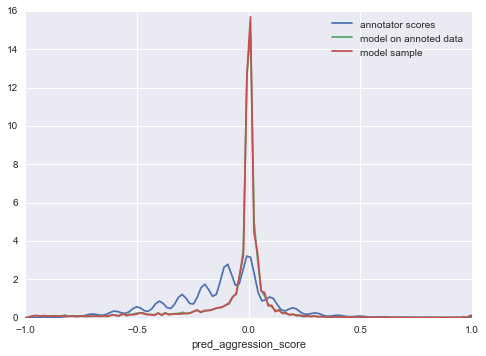

In [40]:
# annotations
sns.distplot(d['annotated']['aggression_score'].dropna(), hist=False, label = 'annotator scores')

# model on annotated data
sns.distplot(d['annotated']['pred_aggression_score'].dropna(), hist=False, label = 'model on annoted data')

#model no admin sample
sns.distplot(d['sample']['pred_aggression_score'].dropna(), hist=False, label = 'model sample')

plt.xlim(-1, 1)
plt.legend()

### Q: How does the distribution over attack probabilities compare across annotators vs models and different data sets

This is mainly a sanity check that the attack model is working new data

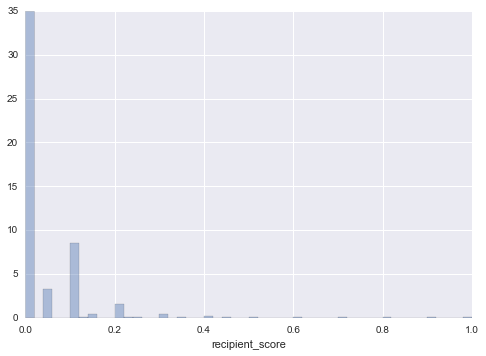

In [43]:
sns.distplot(d['annotated']['recipient_score'].dropna(), kde =False, norm_hist = True)

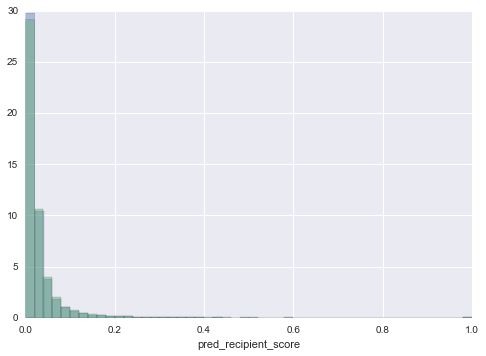

In [44]:
sns.distplot(d['annotated']['pred_recipient_score'].dropna(), kde =False, norm_hist = True)
sns.distplot(d['sample']['pred_recipient_score'].dropna(), kde =False, norm_hist = True)

# Quantifying Prevalence of Personal Attacks

### Q: What fraction of comments are personal attacks?

Methodology 1:
Let p be the proportion of comments that where labled as a personal attack by more than half the annotators. 
Treat p as a random variable, with a weak/uniform beta prior. Compute posterior distribution of p using the number of comments and the number of comments labeled as attacks. Form 95% credible interval using the posterior.

In [70]:
from numpy.random import  beta

def get_credible_interval(num_events, num_trials, conf, num_samples = 50000):
    dist = beta(num_events+1, num_trials-num_events+1, num_samples)
    lower = (100.0 - conf)/2.0
    upper = conf + lower
    return tuple(np.percentile(dist, [lower, upper]))
    

In [71]:
# annotators:
"Fraction of comments labeled as attacks: (%.3f, %.3f)" % get_credible_interval(d['annotated']['recipient'].sum(), d['annotated'].shape[0], 95)

'Fraction of comments labeled as attacks: (0.007, 0.009)'

In [72]:
# model on annotator data Note: this is currently not kosher since the model was trained on this data
"Fraction of comments labeled as attacks: (%.3f, %.3f)" % get_credible_interval(d['annotated']['pred_recipient'].sum(), d['annotated'].shape[0], 95)

'Fraction of comments labeled as attacks: (0.005, 0.007)'

In [73]:
# model sample data: Not really meaninggful, just a comparison
"Fraction of comments labeled as attacks: (%.3f, %.3f)" % get_credible_interval(d['sample']['pred_recipient'].sum(), d['sample'].shape[0], 95)

'Fraction of comments labeled as attacks: (0.005, 0.006)'

Methodology 2: Compute fraction of comments predicted to be attacks for different classification thresholds

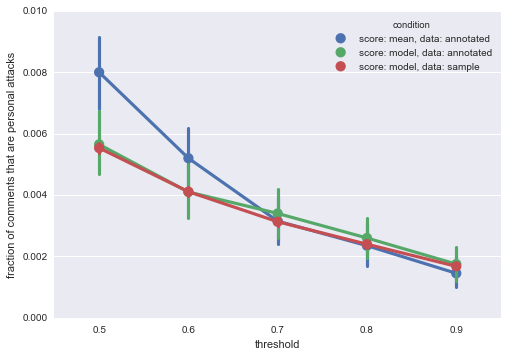

In [74]:
ts = np.arange(0.5, 0.91, 0.1)

# score = mean of annotations
d_aa = pd.concat([pd.DataFrame({'threshold': t, 'attack': d['annotated']['recipient_score'] >= t }) for t in ts], axis = 0)
d_aa['condition'] = 'score: mean, data: annotated'

# score = model score on annotated data
d_ma = pd.concat([pd.DataFrame({'threshold': t, 'attack': d['annotated']['pred_recipient_score'] >= t }) for t in ts], axis = 0) 
d_ma['condition'] = 'score: model, data: annotated'

# score = model score on sample data
d_ms = pd.concat([pd.DataFrame({'threshold': t, 'attack': d['sample']['pred_recipient_score'] > t }) for t in ts], axis = 0) 
d_ms['condition'] = 'score: model, data: sample' 

sns.pointplot(x="threshold", y="attack", hue="condition", data=pd.concat([d_aa, d_ma, d_ms]))
plt.ylabel('fraction of comments that are personal attacks')

Methodology 3: 
For each comment, label it as a personal attack with the probability assigned by the model/annotators. Count the number of comments labeled as personal attacks. Repeat to get a distribtion and take 95% interval.

In [75]:
def compute_ci(a, n = 1000):
    m = a.shape[0]
    v = a.values.reshape((m,1))
    fs = np.sum(np.random.rand(m, n) < v, axis = 0) / m
    print("Fraction of comments labeled as attacks: (%.4f, %.4f)" % ( np.percentile(fs, 2.5), np.percentile(fs, 97.5)))
    
    
# annotator probs
print('Scores: mean annotation, Data: annotated')
compute_ci(d['annotated']['recipient_score'])

# model probs on annotator data
print('Scores: model, Data: annotated')
compute_ci(d['annotated']['pred_recipient_score'])

# model on sample data
print('Scores: model, Data: sample')
compute_ci(d['sample']['pred_recipient_score'])

Scores: mean annotation, Data: annotated
Fraction of comments labeled as attacks: (0.0364, 0.0413)
Scores: model, Data: annotated
Fraction of comments labeled as attacks: (0.0331, 0.0379)
Scores: model, Data: sample
Fraction of comments labeled as attacks: (0.0354, 0.0362)


### Q: What fraction of users have made a personal attack?

Methodology 1: Take unsampled data. Compute fraction of people who authored one comment above the threshold for different thresholds.

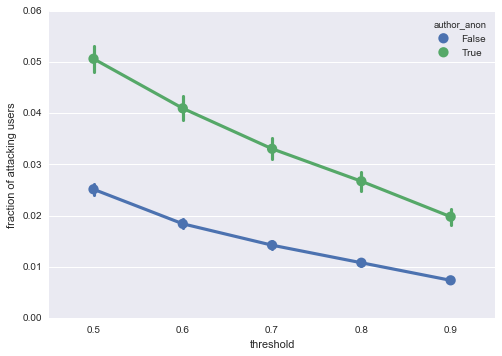

In [77]:
ts = np.arange(0.5, 0.91, 0.1)
dfs = []

for t in ts:
    
    dfs.append (\
                d['2015'].assign(attack= lambda x: x.pred_recipient_score > t)\
                .groupby(['user_text', 'author_anon'], as_index = False)['attack'].max()\
                .assign(threshold = t)
                )
sns.pointplot(x='threshold', y = 'attack', hue = 'author_anon', data = pd.concat(dfs))
plt.ylabel('fraction of attacking users')

Methodology 2: Take unsampled data. For each comment, let it be an attack with proabbility equal to the model prediction. Count the number of users that have made at least 1 attack. Repeat.

In [79]:
def simulate_num_attacks(df, group_col = 'user_text', bias = 0.0):
    n = df.assign( uniform = np.random.rand(df.shape[0], 1))\
            .assign(is_attack = lambda x: ((x.pred_recipient_score + bias) > x.uniform).astype(int))\
            .groupby(group_col)['is_attack']\
            .max()\
            .sum()
    return n

In [80]:
n_attacks = [simulate_num_attacks(d['2015']) for i in range(100)]        
np.percentile(n_attacks, [2.5, 97.5]) / len(d['2015'].user_text.unique())  

array([ 0.13261797,  0.13556789])

In [81]:
# ignore anon users
d_temp = d['2015'].query('not author_anon and not recipient_anon')
n_attacks = [simulate_num_attacks(d_temp) for i in range(100)]        
np.percentile(n_attacks, [2.5, 97.5]) / len(d_temp.user_text.unique())  

array([ 0.13692117,  0.14032371])

### Q: What fraction of users have been attacked?

Methodology: Take unsampled data. Compute fraction of people who recieved one comment above the threshold for different thresholds. TODO: why have there been so many more attackers and victims? Compute ratio of attacks received by user and order user by that ratio.


Note: do not include comments made by the user on their own page.

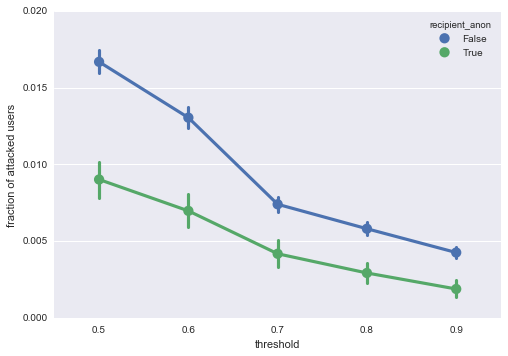

In [82]:
dfs = []

for t in ts:
    
    dfs.append (\
                d['2015'].query('not own_page')\
                .assign(attack = lambda x: x.pred_recipient_score >= t)\
                .groupby(['page_title', 'recipient_anon'], as_index = False)['attack'].max()\
                .assign(threshold = t)
                )
sns.pointplot(x='threshold', y = 'attack', hue = 'recipient_anon', data = pd.concat(dfs))
plt.ylabel('fraction of attacked users')

Methodology 2: Take unsampled data. For each comment, let it be an attack with probability equal to the model prediction. Count the number of users that have received at least 1 attack. Repeat.

In [83]:
n_attacks = [simulate_num_attacks(d['2015'], group_col = 'page_title') for i in range(10)]        
np.percentile(n_attacks, [2.5, 97.5]) / len(d['2015'].page_title.unique()) 

array([ 0.09798288,  0.09931467])

In [84]:
# ignore anon users
d_temp = d['2015'].query('not author_anon and not recipient_anon')
n_attacks = [simulate_num_attacks(d_temp, group_col = 'page_title') for i in range(10)]        
np.percentile(n_attacks, [2.5, 97.5]) / len(d_temp.page_title.unique()) 

array([ 0.1004873 ,  0.10291657])

### Q: What fraction of attacking users have been blocked for harassment?

TODO: Also consider just registered users 

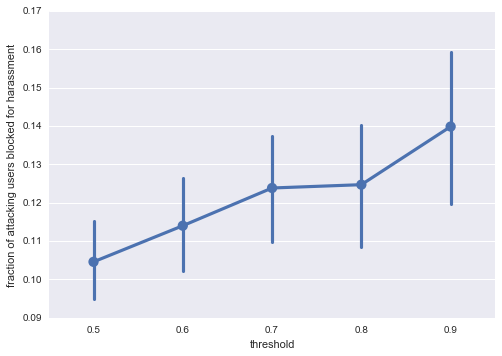

In [85]:
dfs = []

for t in ts:
    dfs.append(\
                d['2015'].query('pred_recipient_score >= %f' % t)[['user_text', 'author_anon']]\
                .drop_duplicates()\
                .merge(df_blocked_user_text, how = 'left', on = 'user_text')\
                .assign(blocked = lambda x: x.blocked.fillna(0),
                        threshold = t)
               )
df = pd.concat(dfs)

sns.pointplot(x = 'threshold', y = 'blocked', data = df)
plt.ylabel('fraction of attacking users blocked for harassment')

### Q: What fraction of attacking comments that come from users blocked for harassment?

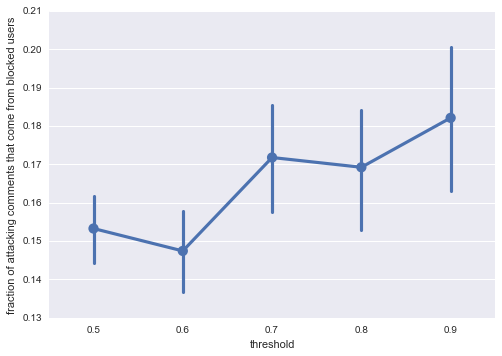

In [88]:
dfs = []


for t in ts:
    dfs.append(\
                d['2015'].query('pred_recipient_score >= %f' % t)[['rev_id', 'author_anon']]\
                .merge(d['blocked'], how = 'left', on = 'rev_id')\
                .assign(blocked = lambda x: x.blocked.fillna(0),
                        threshold = t)
               )
df = pd.concat(dfs)

sns.pointplot(x = 'threshold', y = 'blocked', data = df)
plt.ylabel('fraction of attacking comments that come from blocked users')

### Q: What fraction of attacking comments were followed by a block event?
Within one week

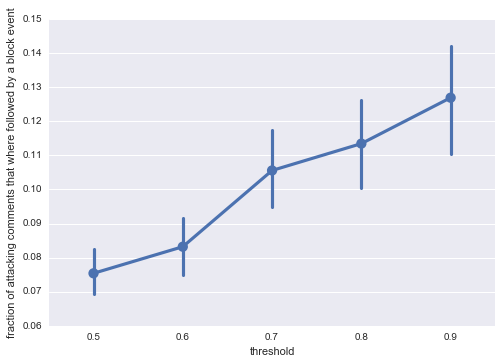

In [89]:
dfs = []
for t in ts:
    
    dfs.append(
                d['2015'].query('pred_recipient_score >= %f' % t)\
                        .loc[:, ['user_text', 'rev_id', 'rev_timestamp']]\
                        .merge(df_events, how = 'left', on = 'user_text')\
                        .assign(delta = lambda x: (x['timestamp'] - x['rev_timestamp']))\
                        .assign(blocked= lambda x: (x['delta'] <  pd.Timedelta('7 days')) & (x['delta'] >  pd.Timedelta('0 seconds')))\
                        .drop_duplicates(subset = 'rev_id')\
                        .assign(threshold = t)
                )
ax = sns.pointplot(x='threshold', y='blocked', data = pd.concat(dfs))
plt.xlabel('threshold')
plt.ylabel('fraction of attacking comments that where followed by a block event')

### Q: How does the probablity of a user being blocked change with the number of attacking comments?

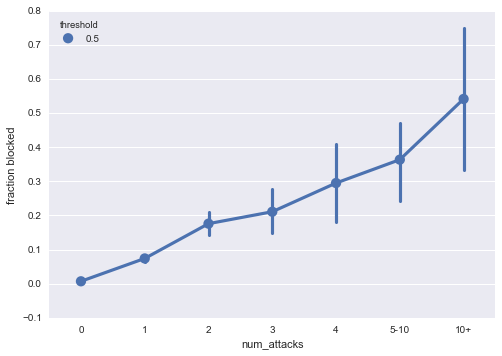

In [90]:
def remap(x):
    if x < 5:
        return str(int(x))
    if x < 10:
        return '5-10'
    else:
        return '10+'
    
t = 0.5 

        
d_temp = d['2015'].assign(attack = lambda x: x.pred_recipient_score >=  t)\
                .groupby('user_text', as_index = False)['attack'].sum()\
                .rename(columns={'attack':'num_attacks'})\
                .merge(df_blocked_user_text, how = 'left', on = 'user_text')\
                .assign(
                    blocked = lambda x: x.blocked.fillna(0,),
                    num_attacks = lambda x: x.num_attacks.apply(remap),
                    threshold = t)
                
ax = sns.pointplot(x='num_attacks', y= 'blocked', data=d_temp, hue = 'threshold', order = ('0', '1', '2', '3', '4', '5-10', '10+'))
plt.ylabel('fraction blocked')

### Q: How are aggression and personal attacks related? Is it just the attacks that are aggressive or are their other types if aggression?

Methodology: check pearson correlation between aggression and attack scores for sample or unsampled data.

In [91]:
d_temp = d['annotated'].dropna(subset=['aggression_score', 'recipient_score'])
pearson(d_temp['aggression_score'],d_temp['recipient_score'])

0.4727576891648364

In [92]:
d_temp = d['annotated'].dropna(subset=['pred_aggression_score', 'pred_recipient_score'])
pearson(d_temp['pred_aggression_score'],d_temp['pred_recipient_score'])

0.41088860679940226

In [94]:
pearson(d['sample']['pred_aggression_score'],d['sample']['pred_recipient_score'])

0.41280514154870407

# Group Comparisons

Lets break down data into different groups and compare the mean aggression and attack scores

In [95]:
def mpg(df, score, cols):
    """
    return row with max score in each group of cols values
    """
    return df.sort(score, ascending=False).groupby(cols, as_index=False).first()

def compare_groups(df, x, mpu = False, order = None, hue = None, plot = True, table = True):
    agg = 'pred_aggression_score'
    rec = 'pred_recipient_score'
    
    if table:
        if hue:
            print(df.groupby([x, hue])[agg, rec].mean())
        else:
            print(df.groupby([x])[agg, rec].mean())
    
    if plot:
        
        fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize = (12,6))

        if mpu:
            cols = ['user_text', x]
            plt.figure()
            sns.pointplot(x=x, y= agg, data=mpg(df, agg, cols) , order = order, hue = hue, ax = ax1)
            plt.figure()
            sns.pointplot(x=x, y= rec, data=mpg(df, rec, cols) , order = order, hue = hue, ax = ax2)
        else:
            
            ax = sns.pointplot(x=x, y= agg, data=df, order = order, hue = hue, ax = ax1)
            plt.figure()
            ax = sns.pointplot(x=x, y= rec, data=df, order = order, hue = hue, ax = ax2)
            

### Q: How do comments made by registered and anonymous authors compare?

             pred_aggression_score  pred_recipient_score
author_anon                                             
False                    -0.055197              0.032946
True                      0.080100              0.096603


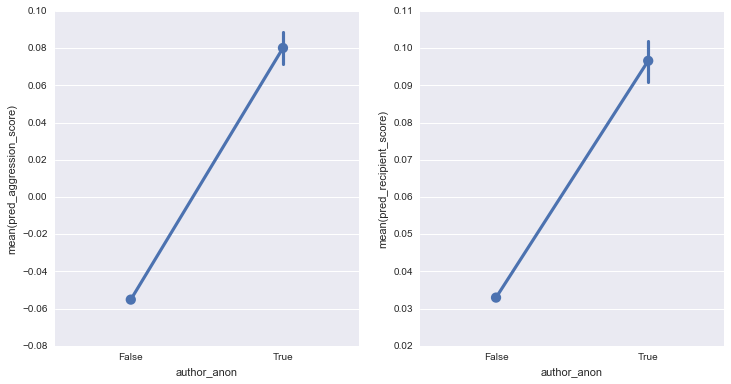

In [101]:
o = (False, True)
x = 'author_anon'
compare_groups(d['sample'][:100000], x, order = o)

In [119]:
#x = 'author_anon'
#plot_scores(df_no_admin_2015, x, order = o)

### Q: How do comments received by registered and anonymous authors compare?

                pred_aggression_score  pred_recipient_score
recipient_anon                                             
False                       -0.057084              0.034873
True                        -0.034437              0.030891


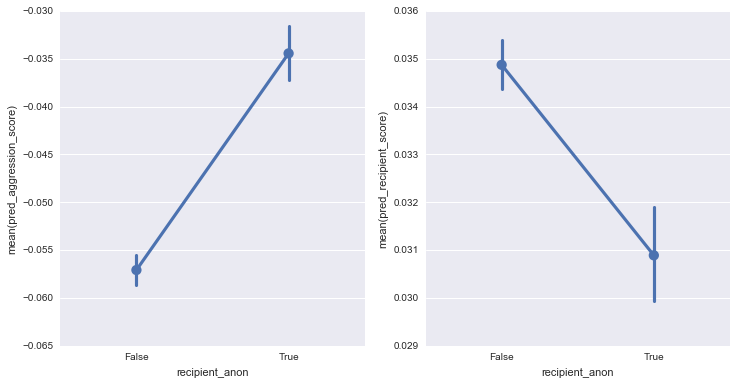

In [100]:
# don't count posts to own article
x = 'recipient_anon'
compare_groups(d['sample'][:100000].query('not own_page'), x, order = o)

In [59]:
#x = 'recipient_anon'
#plot_scores(df_no_admin_2015, x, order = o)

### Q: How do authors write differently on their own page than on other pages?

          pred_aggression_score  pred_recipient_score
own_page                                             
False                 -0.054011              0.034333
True                  -0.030057              0.041521


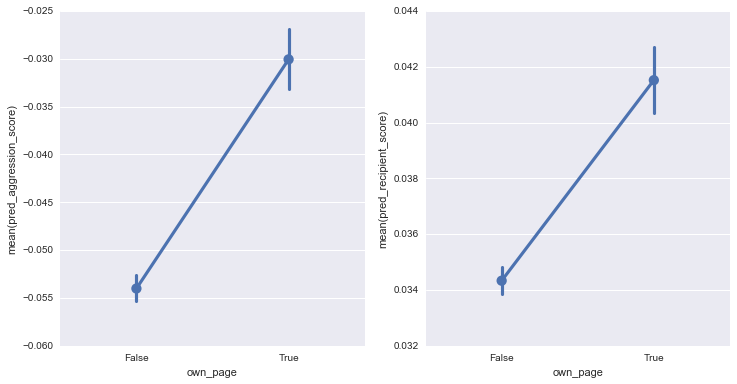

In [103]:
x = 'own_page'
o = (False, True)
compare_groups(d['sample'][:100000], x, order = o)

                      pred_aggression_score  pred_recipient_score
own_page author_anon                                             
False    False                    -0.059323              0.031784
         True                      0.064165              0.091044
True     False                    -0.038867              0.037544
         True                      0.132372              0.114837


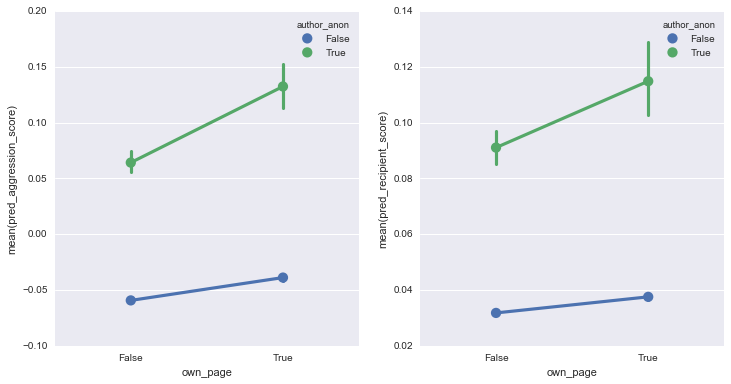

In [104]:
x = 'own_page'
compare_groups(d['sample'][:100000], x, order = o, hue = 'author_anon')

## Time

### Q: Has the amount of aggressiveness and attacks changed year over year?

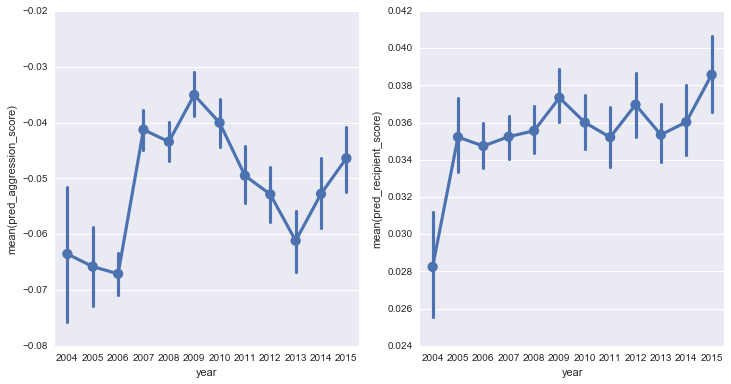

In [105]:
df_span = d['sample'][:100000].query('year > 2003 & year < 2016')
x = 'year'
o = range(2004, 2016)
compare_groups(df_span, x, order = o, table = False)

### Q: Is there a seasonal effect?

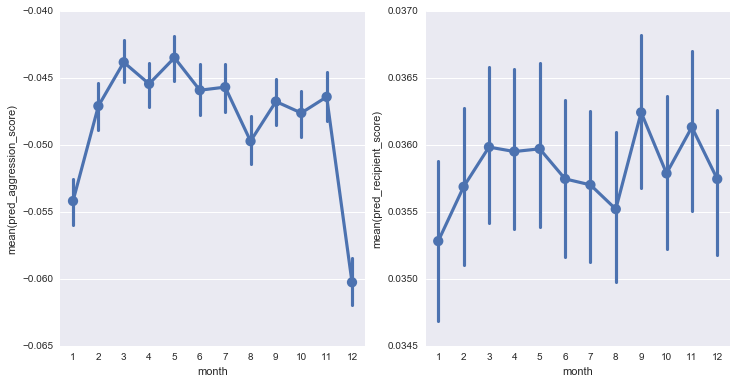

In [109]:
x = 'month'
o = range(1, 13)
compare_groups(d['sample'], x, order = o, table = False)

### Q: Is there an hour of day effect?

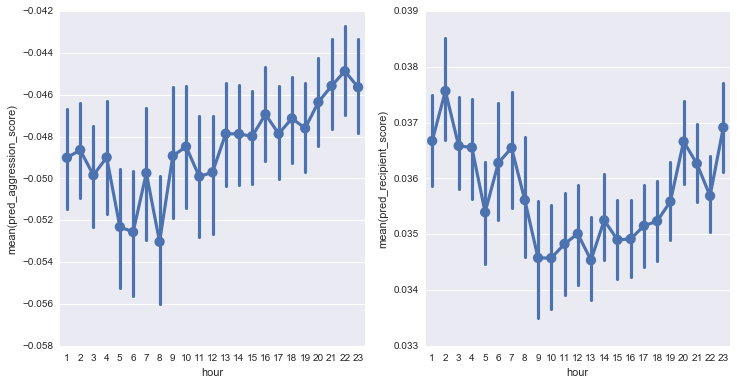

In [108]:
x = 'hour'
o  = range(1, 24)
compare_groups(d['sample'], x, order = o, table = False)

## Gender

In [150]:
from db_utils import query_analytics_store

In [110]:
## Annotate users by gender
query = """
SELECT
    user_id,
    user_name as user_text,
    up_value as gender
FROM
    enwiki.user_properties p,
    enwiki.user u
WHERE 
    p.up_user = u.user_id
    AND up_property = 'gender'
"""
#d_gender = query_analytics_store(query, {})
#d_gender.to_csv('genders.tsv', sep = '\t', index = False)
d_gender = pd.read_csv('genders.tsv', sep = '\t')

In [112]:
def remap_author_gender(r):
    if r['gender'] == 'male':
        return 'male'
    elif r['gender'] == 'female':
        return 'female'
    elif r['author_anon']:
        return 'unknown:anon'
    else:
        return 'unknown: registered'
    
    
df_no_admin_gender = d['2015'].\
                     merge(d_gender, how = 'left', on = 'user_id', suffixes = ('', '_x')).\
                     assign(author_gender = lambda x: x.apply(remap_author_gender, axis = 1)).\
                     drop(['gender', 'user_text_x'], axis=1)

In [113]:
def remap_recipient_gender(r):
    if r['gender'] == 'male':
        return 'male'
    elif r['gender'] == 'female':
        return 'female'
    elif r['recipient_anon']:
        return 'unknown:anon'
    else:
        return 'unknown: registered'
    
df_no_admin_gender = df_no_admin_gender.\
                     merge(d_gender, how = 'left', left_on = 'page_title', right_on = 'user_text', suffixes = ('', '_x')).\
                     assign(recipient_gender = lambda x: x.apply(remap_recipient_gender, axis = 1)).\
                     drop(['gender', 'user_text_x', 'user_id_x'], axis=1)

In [114]:
df_no_admin_gender.author_gender.value_counts()

unknown: registered    524267
male                   351570
unknown:anon            56543
female                  48485
Name: author_gender, dtype: int64

In [115]:
df_no_admin_gender.recipient_gender.value_counts()

unknown: registered    583758
male                   304166
unknown:anon            48223
female                  44718
Name: recipient_gender, dtype: int64

### Q: What is the effect of the author's gender?

                     pred_aggression_score  pred_recipient_score
author_gender                                                   
female                           -0.098558              0.033322
male                             -0.076705              0.030826
unknown: registered              -0.057319              0.037918
unknown:anon                      0.159108              0.077585


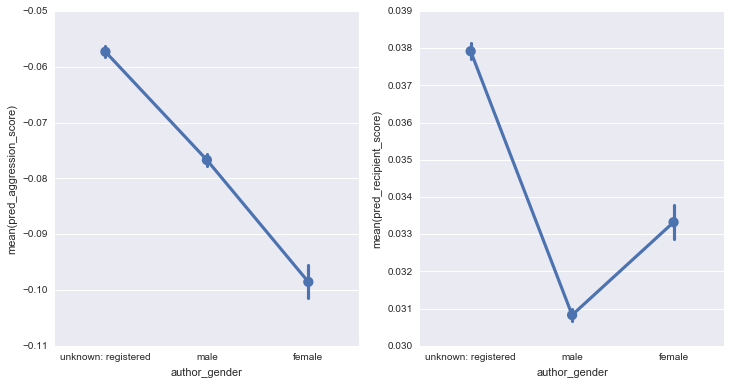

In [72]:
o = ('unknown: registered', 'male', 'female')
x = 'author_gender'
compare_groups(df_no_admin_gender, x, order = o)

### Q: What is the effect of the recipient's gender?

                     pred_aggression_score  pred_recipient_score
recipient_gender                                                
female                           -0.069668              0.037555
male                             -0.052091              0.039116
unknown: registered              -0.054627              0.036913
unknown:anon                     -0.006574              0.040416


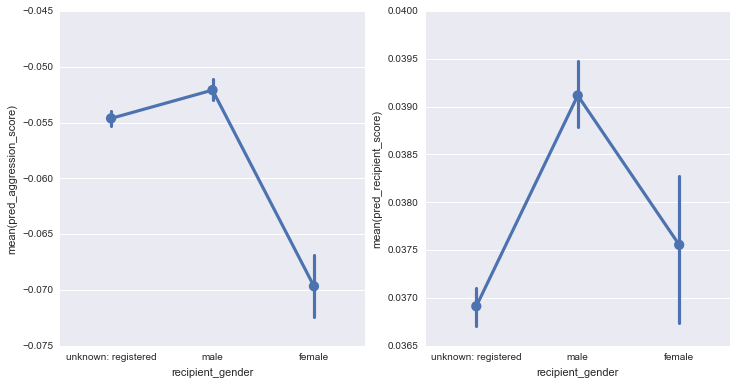

In [116]:
o = ('unknown: registered', 'male', 'female')
x = 'recipient_gender'
compare_groups(df_no_admin_gender.query('not own_page'), x, order= o)

### Q: How does the effect change when you interact author and recipient gender?

                                         pred_aggression_score  \
recipient_gender    author_gender                                
female              female                           -0.105718   
                    male                             -0.066547   
                    unknown: registered              -0.077708   
male                female                           -0.088438   
                    male                             -0.062105   
                    unknown: registered              -0.056973   
unknown: registered female                           -0.075662   
                    male                             -0.048264   
                    unknown: registered              -0.066904   
unknown:anon        female                           -0.029653   
                    male                             -0.015713   
                    unknown: registered              -0.009921   

                                         pred_recipient_score  
recipient_g

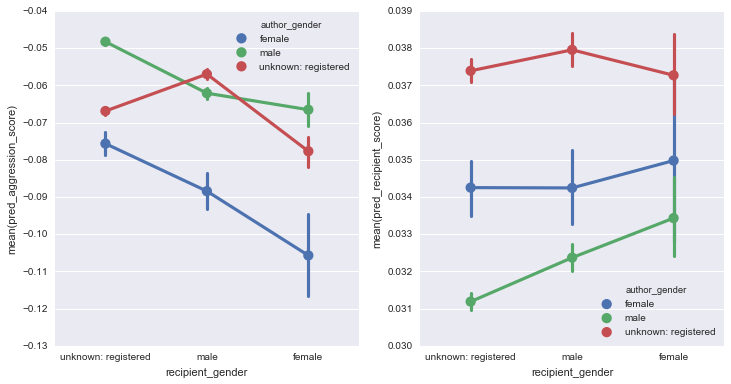

In [117]:
o = ('unknown: registered', 'male', 'female')
x = 'recipient_gender'
compare_groups(df_no_admin_gender.query("not own_page and author_gender != 'unknown:anon'"), x, order = o, hue = 'author_gender')

### Q: Is tone reciprocal?

Methodology 1: is the average aggression score of what A says on B's page related to the average score of what B says on A's page?

In [169]:
pairs = d['2015'].query('not own_page and not author_anon and not recipient_anon')\
                     .groupby(['user_text', 'page_title'], as_index = False)['pred_aggression_score']\
                     .agg({'aggresssivness': np.mean, 'count': len})\
                     .query('count > 5')\
                     .assign(key = lambda x: 'From:' + x['user_text'] + ' to:' + x['page_title'],
                                partner_key = lambda x: 'From:' + x['page_title'] + ' to:' + x['user_text']
                               )
            
       
        
pairs = pairs.merge(pairs, left_on = 'partner_key', right_on = 'key', how = 'inner' )

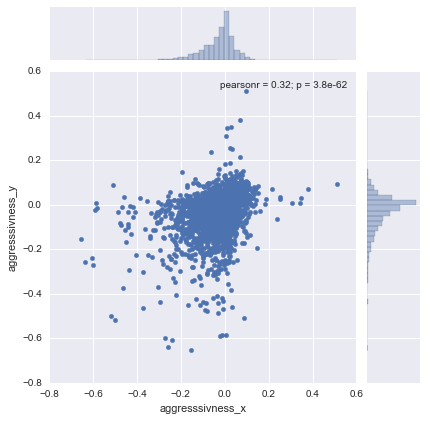

In [170]:
sns.jointplot(x = 'aggresssivness_x', y = 'aggresssivness_y', data = pairs)

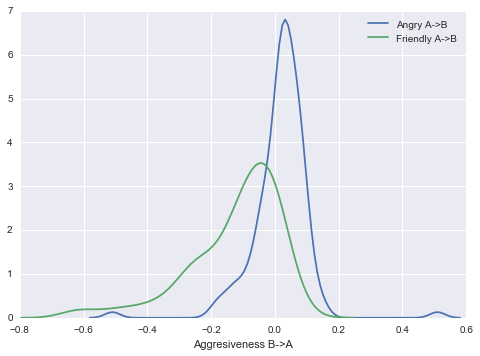

In [172]:
t_angry = np.percentile(pairs['aggresssivness_x'], 95)
t_friendly = np.percentile(pairs['aggresssivness_y'], 5)

sns.distplot(pairs.query('aggresssivness_x > %f' % t_angry)['aggresssivness_y'], hist=False, label = 'Angry A->B')
sns.distplot(pairs.query('aggresssivness_x < %f' % t_friendly)['aggresssivness_y'], hist=False, label = 'Friendly A->B')
plt.xlabel('Aggresiveness B->A')

Methodology 2: is the aggression score of what A says on B's page related to the score of the next thing B says on A's page?

In [122]:
cols =  ['user_text', 'page_title', 'clean_diff', 'pred_aggression_score', 'rev_timestamp', 'rev_id']
ab = d['2015'].query('not own_page and not author_anon and not recipient_anon')[cols]
ba = ab.copy().rename(columns = {'user_text': 'page_title', 'page_title': 'user_text'})[cols]

micro_pairs = ab.merge(ba, on = ['user_text', 'page_title'], how = 'inner' )\
                .assign(delta = lambda x: x['rev_timestamp_x'] - x['rev_timestamp_y'])\
                .assign(delta_positive = lambda x: x.delta >  pd.Timedelta('0 seconds'),
                        delta_less_30 = lambda x: x.delta <  pd.Timedelta('30 days'))\
                .query('delta_positive and delta_less_30')\
                .sort('delta', ascending=False)\
                .groupby('rev_id_x', as_index=False).first()

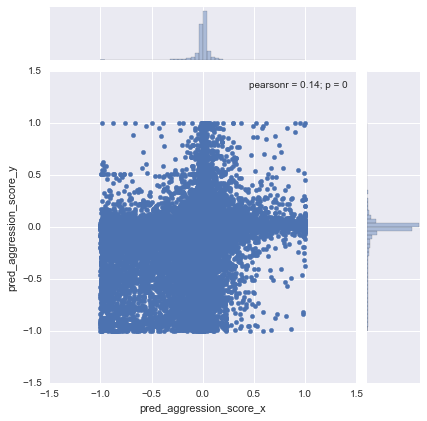

In [123]:
sns.jointplot(x = 'pred_aggression_score_x', y = 'pred_aggression_score_y', data = micro_pairs)

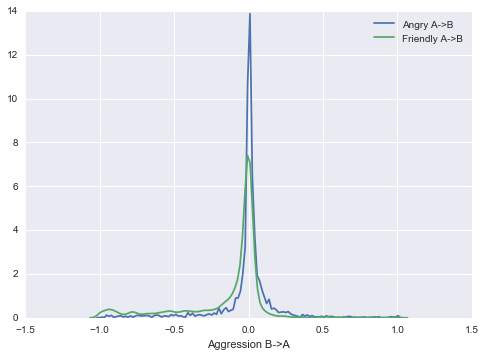

In [125]:
t_friendly, t_neutral, t_angry = np.percentile(micro_pairs['pred_aggression_score_x'], (5, 50, 95))


sns.distplot(micro_pairs.query('pred_aggression_score_x > %f' % t_angry)['pred_aggression_score_y'], hist=False, label = 'Angry A->B')
sns.distplot(micro_pairs.query('pred_aggression_score_x < %f' % t_friendly)['pred_aggression_score_y'], hist=False, label = 'Friendly A->B')

plt.xlabel('Aggression B->A')

### Q: Saintliness vs. Provocativeness

In [186]:
out_score = d['2015'].query('not own_page and not author_anon and not recipient_anon')\
                     .groupby(['user_text'], as_index = False)['pred_aggression_score']\
                     .agg({'out_score': np.mean, 'count': len})\
                     .query('count > 5')
            
in_score = d['2015'].query('not own_page and not author_anon and not recipient_anon')\
                     .groupby(['page_title'], as_index = False)['pred_aggression_score']\
                     .agg({'in_score': np.mean, 'count': len})\
                     .query('count > 5')\
                     .rename(columns = {'page_title':'user_text'})
                    
in_out = out_score.merge(in_score, how = 'inner', on = 'user_text')
in_out['saintliness'] = in_out['out_score'] - in_out['in_score']

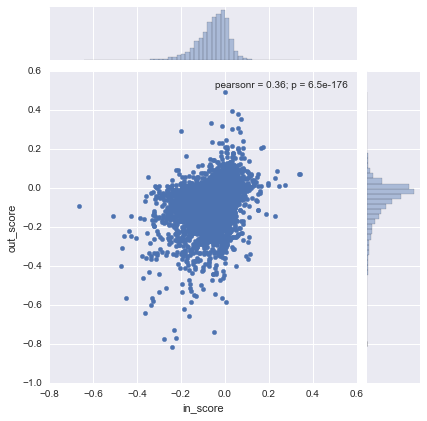

In [187]:
sns.jointplot(x = 'in_score', y = 'out_score', data = in_out)

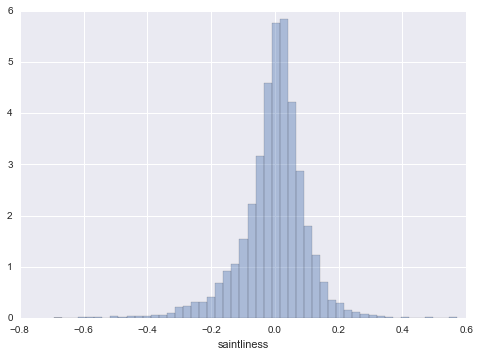

In [188]:
sns.distplot(in_out['saintliness'].dropna(), kde =False, norm_hist = True)

In [181]:
# Saints
in_out.sort_values('saintliness').head(5)

,user_text,count_x,out,count_y,in,saintliness
2139,Hmlarson,63.0,-0.741058,19.0,-0.048037,-0.693021
270,Anastasiageva,6.0,-0.585982,6.0,0.006268,-0.592251
3949,Pjoef,37.0,-0.814339,21.0,-0.240170,-0.574169
3635,Not So Dumb Blond,7.0,-0.562621,9.0,-0.014393,-0.548228
2734,Kelly120913,28.0,-0.770929,7.0,-0.223828,-0.547102


In [193]:
# Saints
in_out.sort_values('saintliness').query('in_score > 0 and out_score < 0' ).head(5)

,user_text,out_score,count_x,count_y,in_score,saintliness
270,Anastasiageva,-0.585982,6.0,6.0,0.006268,-0.592251
411,Asdiprizio,-0.365253,14.0,6.0,0.106791,-0.472043
3566,NicatronTg,-0.336760,7.0,7.0,0.116345,-0.453105
3796,Parenchyma18,-0.401030,10.0,6.0,0.051463,-0.452493
1672,Fettlemap,-0.346774,9.0,6.0,0.095802,-0.442576


In [1]:
d['2015'].query("user_text = 'Parenchyma18'")

NameError: name 'd' is not defined

In [ ]:
# Saints
in_out.sort_values('saintliness').query('in_score > 0 and out_score < 0' ).head(5)

In [182]:
# Provocateurs
in_out.sort_values('saintliness', ascending = False).head(5)

,user_text,count_x,out,count_y,in,saintliness
2818,Koavf,265.0,-0.089716,11.0,-0.661678,0.571962
2681,Kalakannija,7.0,0.494434,6.0,0.000871,0.493563
3335,Missionedit,560.0,0.291147,181.0,-0.200858,0.492004
4449,Satya durga reddy,12.0,0.055227,6.0,-0.348728,0.403956
2364,JackETC,6.0,0.333471,8.0,-0.061958,0.395429


In [194]:
# Provocateurs
in_out.sort_values('saintliness', ascending = False).query('out_score > 0 and in_score < 0').head(5)

,user_text,out_score,count_x,count_y,in_score,saintliness
3335,Missionedit,0.291147,560.0,181.0,-0.200858,0.492004
4449,Satya durga reddy,0.055227,12.0,6.0,-0.348728,0.403956
2364,JackETC,0.333471,6.0,8.0,-0.061958,0.395429
4529,Shadowxfox,0.163102,8.0,6.0,-0.176536,0.339638
244,Alvandria,0.320585,8.0,14.0,-0.011418,0.332003


### Q: How does tone depend on the frequency of commenting?

Methodology: let the "aggressiveness" of a user be the averge aggression_score of all their comments. Compare aggression scores across groups of users based on how much the post

In [126]:
tresholds = np.percentile(d['2015']['user_text'].value_counts(),  np.arange(0, 100.01,0.5 ))
tresholds = sorted(set(tresholds.astype(int)))

In [127]:
bins = []
for i in range(len(tresholds)-1):
    label = '%d-%d' % (tresholds[i], tresholds[i+1]-1)
    rnge = range(tresholds[i], tresholds[i+1])
    bins.append((label, rnge))

In [128]:
def map_count(x):
    for label, rnge in bins:
        if x in rnge:
            return label
        
        
d_temp = d['2015'].query('not author_anon')\
                 .groupby('user_text')['pred_aggression_score']\
                 .agg( {'aggressiveness': np.mean, 'count': len})\
                 .assign(num_comment_range = lambda x: x['count'].apply(map_count))

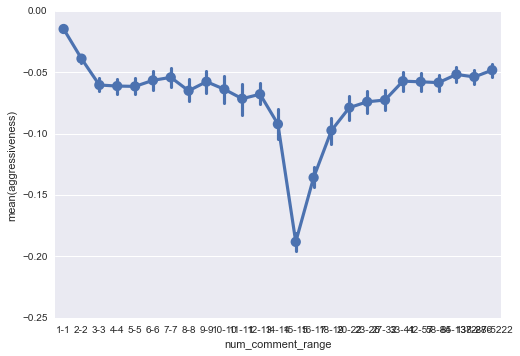

In [129]:
o = [e[0] for e in bins]
sns.pointplot(x='num_comment_range', y= 'aggressiveness', data= d_temp, order = o)

# Blocked Users

### Summary Stats

In [198]:
print('# block events:')
df_events.shape[0]

# block events:


27343

In [199]:
print('# block events')
df_events.groupby('anon').size()

# block events


anon
False    12377
True     14966
dtype: int64

In [200]:
print('# blocked users')
df_events.groupby('anon').user_text.nunique()

# blocked users


anon
False    10106
True     13562
Name: user_text, dtype: int64

In [209]:
print('# blocked users with a public user talk comment')
d['blocked'].groupby('author_anon').user_text.nunique()

# blocked users with a public user talk comment


author_anon
False    5871
True     6210
Name: user_text, dtype: int64

In [210]:
print('fraction of blocked users with a public user talk comment')
d['blocked'].groupby('author_anon').user_text.nunique() / df_events.groupby('anon').user_text.nunique() 

fraction of blocked users with a public user talk comment


author_anon
False    0.580942
True     0.457897
Name: user_text, dtype: float64

### Q: How many users got blocked multiple times?

In [211]:
df_events.assign(block_count = 1)\
.groupby(['user_text', 'anon'], as_index = False)['block_count'].sum()\
.groupby(['anon', 'block_count']).size()

anon   block_count
False  1               8568
       2               1135
       3                235
       4                 91
       5                 42
       6                 16
       7                  8
       8                  5
       9                  3
       10                 1
       15                 1
       16                 1
True   1              12416
       2                964
       3                136
       4                 32
       5                  5
       6                  5
       7                  3
       10                 1
dtype: int64

### How many user talk comments before first block event?

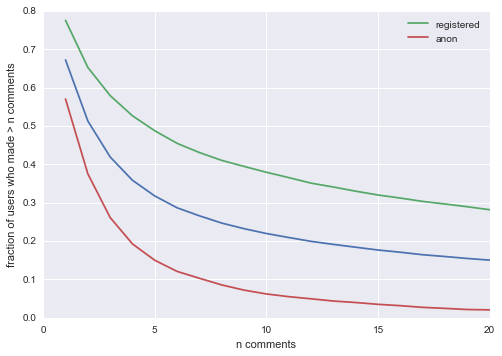

In [212]:
df_first_block = df_events.sort('timestamp')\
                    .groupby(['user_text'], as_index=False).first()[['user_text', 'timestamp']]
    

d = d['blocked'].merge(df_first_block, how = 'inner', on = 'user_text')\
                .assign(delta = lambda x: (x['timestamp'] - x['rev_timestamp']).apply(lambda x: x.days) + 1)\
                .query('delta >=1')
        
def atleast(s):
    s = s.value_counts().value_counts().sort_index()
    n = s.sum()
    return 1 - s.cumsum()/n

s = atleast(d['user_text'])
sr = atleast(d.query('not author_anon')['user_text'])
sa = atleast(d.query('author_anon')['user_text'])

plt.plot(s.head(20), label = '')
plt.plot(sr.head(20), label = 'registered')
plt.plot(sa.head(20), label = 'anon')

plt.xlabel('n comments')
plt.ylabel('fraction of users who made > n comments')
plt.legend()

### How long are users around before their first block event?

In [213]:
d_first_post = d['blocked'].sort('rev_timestamp')\
                    .groupby(['user_text', 'author_anon'], as_index=False).first()\
                    [['user_text', 'author_anon', 'rev_timestamp']]
        
df_first_block = df_events.sort('timestamp')\
                    .groupby(['user_text'], as_index=False).first()[['user_text', 'timestamp']]
    

d = d_first_post.merge(df_first_block, how = 'inner', on = 'user_text')\
                .assign(delta = lambda x: (x['timestamp'] - x['rev_timestamp']).apply(lambda x: x.days) + 1)\
                .query('delta >=1')
        
def atleast(s):
    s = s.value_counts().sort_index()
    n = s.sum()
    return 1 - s.cumsum()/n

s = atleast(d['delta'])
sr = atleast(d.query('not author_anon')['delta'])
sa = atleast(d.query('author_anon')['delta'])

plt.plot(s.head(20), label = '')
plt.plot(sr.head(20), label = 'registered')
plt.plot(sa.head(20), label = 'anon')
plt.legend()

plt.xlabel('n days')
plt.ylabel('fraction of users active for > n days before first block')
plt.legend()

ValueError: This Series is a view of some other array, to sort in-place you must create a copy

### Q: Bad Day or Persistent Troll?

Methodology: Consider bocked users. Histogram over what fraction of comments are bad

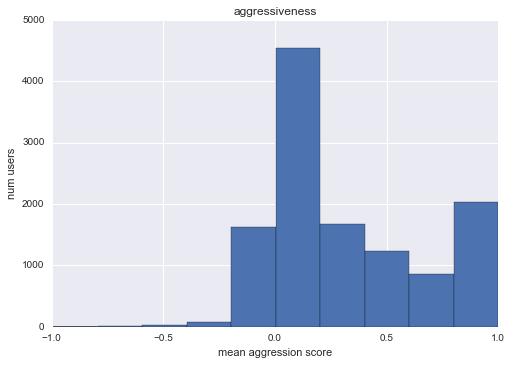

In [195]:
d['blocked'].groupby('user_text')['pred_aggression_score']\
                 .agg( {'aggressiveness': np.mean}).hist()
plt.xlabel('mean aggression score')
plt.ylabel('num users')

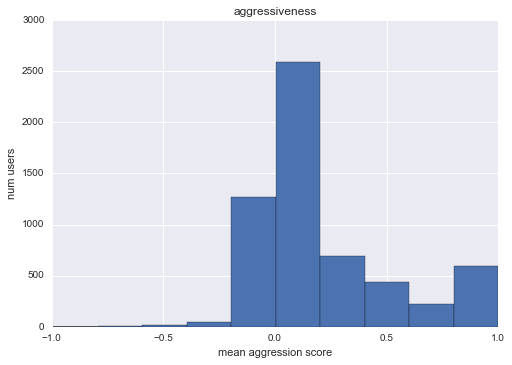

In [196]:
d['blocked'].query('not author_anon').groupby('user_text')['pred_aggression_score']\
                 .agg( {'aggressiveness': np.mean}).hist()
plt.xlabel('mean aggression score')
plt.ylabel('num users')

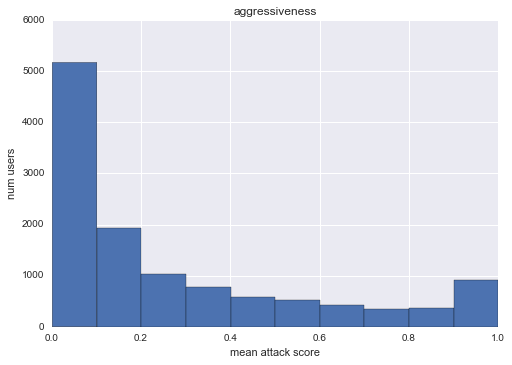

In [197]:
d['blocked'].groupby('user_text')['pred_recipient_score']\
                 .agg( {'aggressiveness': np.mean}).hist()
plt.xlabel('mean attack score')
plt.ylabel('num users')

In [ ]:
d['blocked'].query('not author_anon').groupby('user_text')['pred_recipient_score']\
                 .agg( {'aggressiveness': np.mean}).hist()
plt.xlabel('mean attack score')
plt.ylabel('num users')

## What influence does being blocked have on user behavior?

### Q: P(blocked again | blocked at least k times)

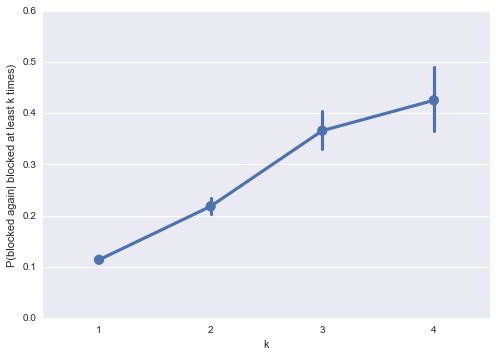

In [232]:
dfs = []

for k in range(1, 5):
    df_k = df_events.assign(blocked = 1)\
            .groupby('user_text', as_index = False)['blocked'].sum()\
            .query('blocked >=%f'%k)
    df_k1 = df_events.assign(blocked = 1)\
            .groupby('user_text', as_index = False)['blocked'].sum()\
            .query('blocked >=%f'%(k+1))\
            .assign(again = 1)
    df = df_k.merge(df_k1, how = 'left', on = 'user_text').assign(again = lambda x: x.again.fillna(0)).assign(k=k)
    dfs.append(df)

sns.pointplot(x = 'k', y = 'again', data = pd.concat(dfs))
plt.xlabel('k')
plt.ylabel('P(blocked again| blocked at least k times)')

### Q: How does the number of block events vary over time?

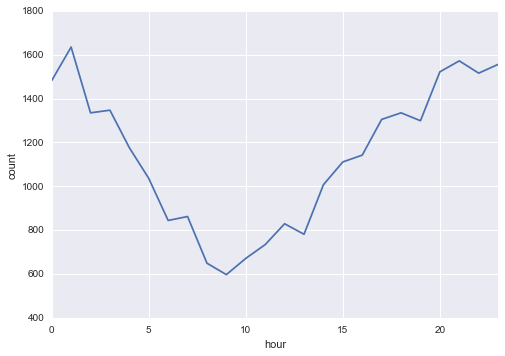

In [158]:
df_events.hour.value_counts().sort_index().plot()
plt.xlabel('hour')
plt.ylabel('count')

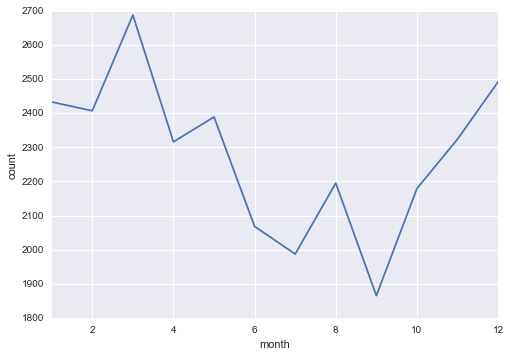

In [159]:
df_events.month.value_counts().sort_index().plot()
plt.xlabel('month')
plt.ylabel('count')

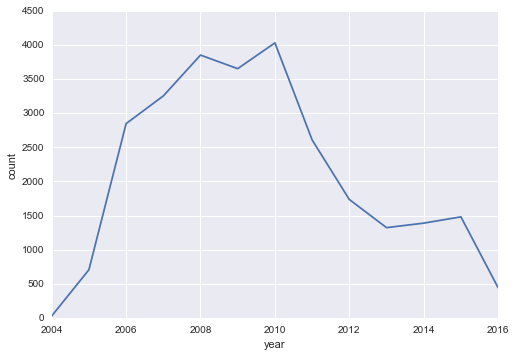

In [160]:
df_events.year.value_counts().sort_index().plot()
plt.xlabel('year')
plt.ylabel('count')

### How many blocked users have a public talk page comment after they where blocked?